Імпорти, необхідні для роботи скрипту:

In [23]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

Визначення констант (шляху для агрегації даних та типів активностей):

In [24]:
base_path = "sources/data"
activities = {"walking": 0, "stairs": 1, "running": 2, "idle": 3}

Функція для завантаження даних з визначеного в константах фолдера:

In [25]:
def load_data(base_path, activity, activity_name):
    files = glob.glob(os.path.join(base_path, f"{activity}/*.csv"))
    data_frames = []
    for f in files:
        data = pd.read_csv(f)
        data["activity"] = activity_name
        data_frames.append(data)
    return pd.concat(data_frames, ignore_index=True)

Завантаження та візуалізація даних:

walking: (55500, 4)
stairs: (4950, 4)
running: (102240, 4)
idle: (31170, 4)


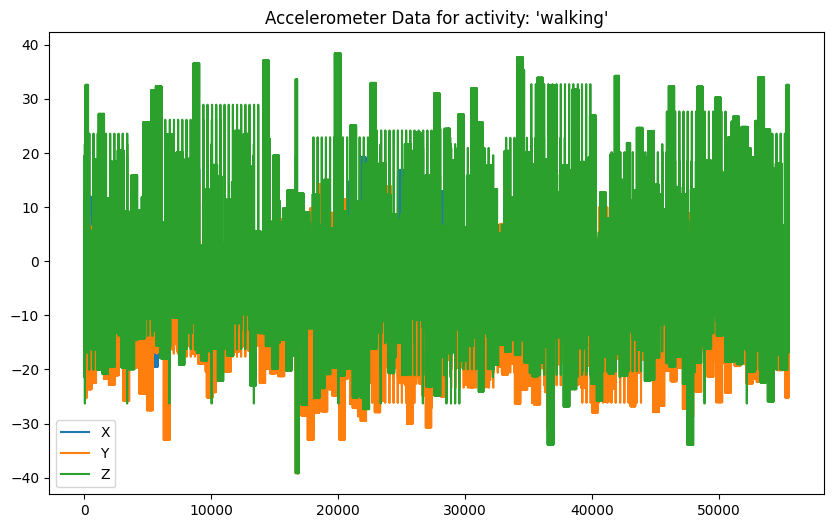

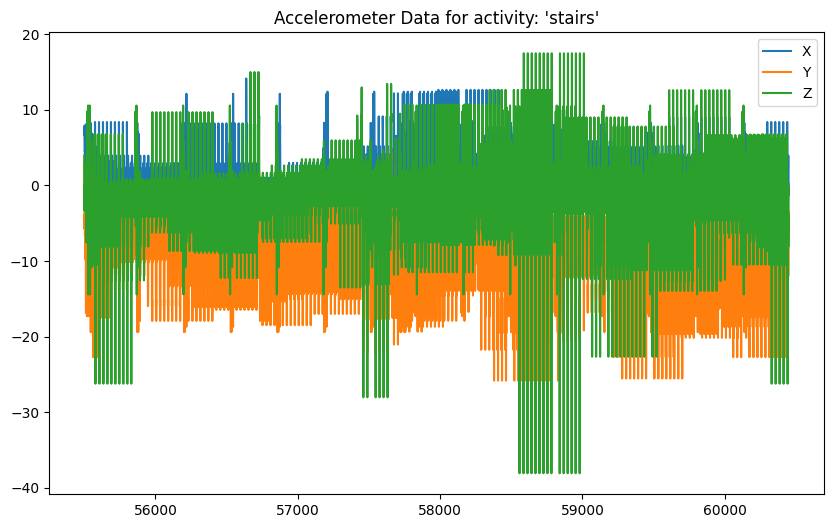

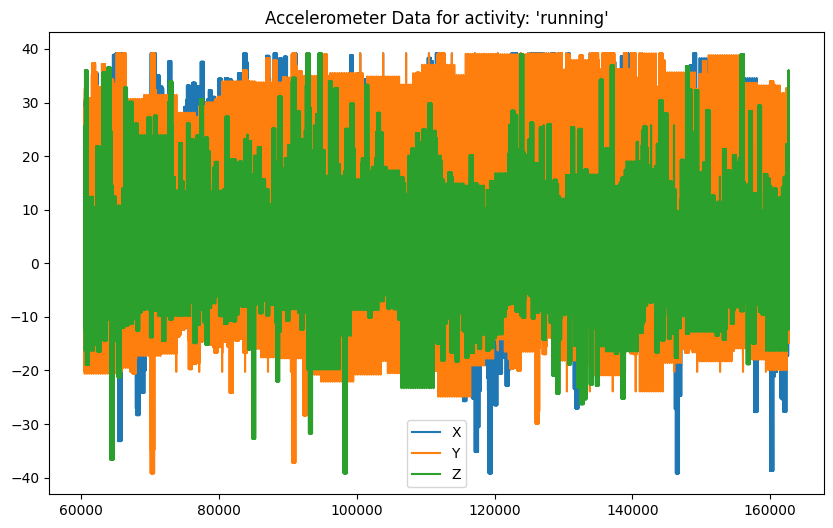

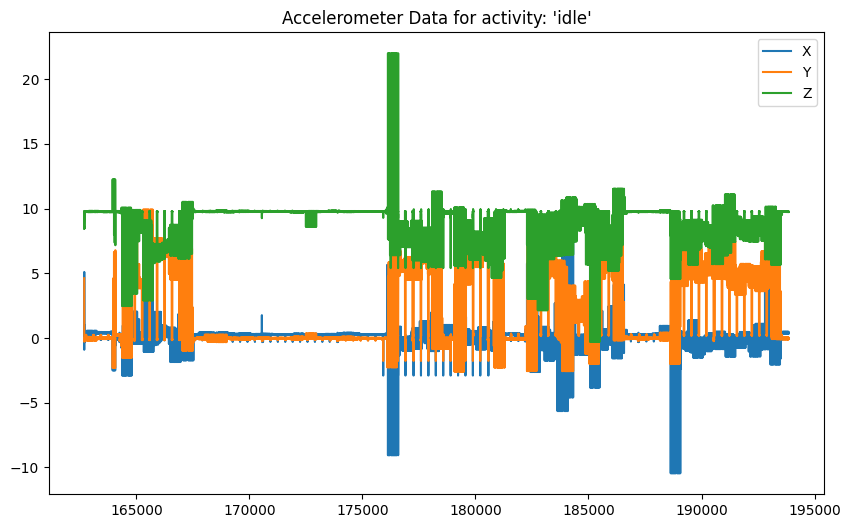

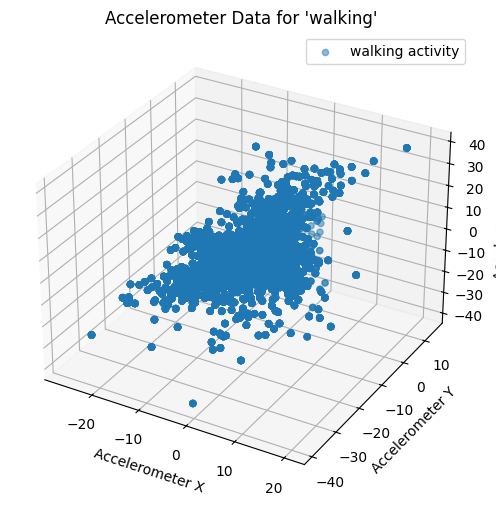

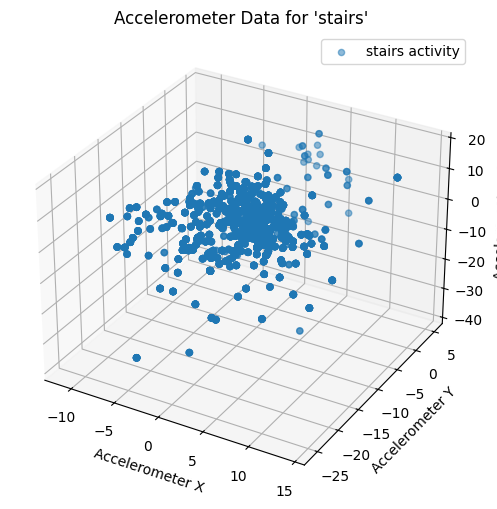

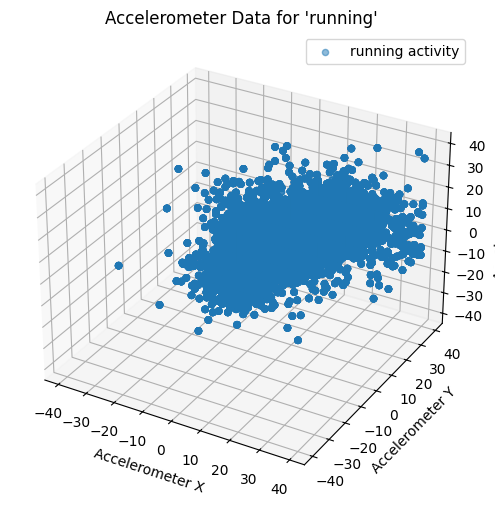

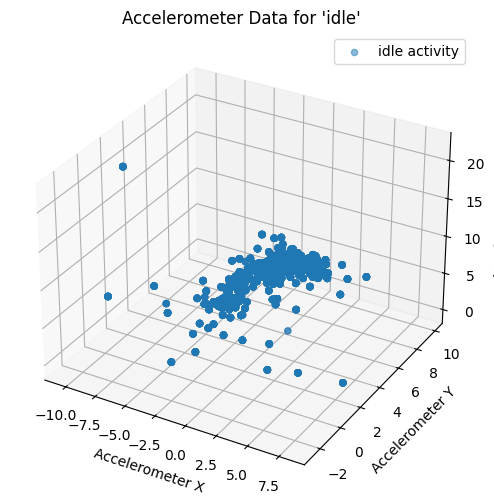

In [26]:
data_frames = []
for activity, activity_name in activities.items():
    activity_data = load_data(base_path, activity, activity_name)
    data_frames.append(activity_data)

all_data = pd.concat(data_frames, ignore_index=True)

for activity, activity_name in activities.items():
    print(f"{activity}: {all_data[all_data['activity'] == activity_name].shape}")

for activity, activity_name in activities.items():
    activity_data = all_data[all_data["activity"] == activity_name]
    plt.figure(figsize=(10, 6))
    plt.plot(activity_data["accelerometer_X"], label="X")
    plt.plot(activity_data["accelerometer_Y"], label="Y")
    plt.plot(activity_data["accelerometer_Z"], label="Z")
    plt.title(f"Accelerometer Data for activity: '{activity}'")
    plt.legend()
    plt.show()

for activity, activity_name in activities.items():
    activity_data = all_data[all_data["activity"] == activity_name]
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        activity_data["accelerometer_X"],
        activity_data["accelerometer_Y"],
        activity_data["accelerometer_Z"],
        label=f"{activity} activity",
        alpha=0.5,
    )
    ax.set_xlabel("Accelerometer X")
    ax.set_ylabel("Accelerometer Y")
    ax.set_zlabel("Accelerometer Z")
    ax.set_title(f"Accelerometer Data for '{activity}'")
    ax.legend()
    plt.show()

Функція для розрахунку часових ознак:

In [27]:
def calculate_time_features(df, window_size=100):
    time_features = []
    labels = []

    for i in range(0, len(df) - window_size, window_size):
        window = df.iloc[i : i + window_size]
        features = []

        for axis in ["accelerometer_X", "accelerometer_Y", "accelerometer_Z"]:
            features.append(window[axis].mean())
            features.append(window[axis].std())
            features.append(window[axis].min())
            features.append(window[axis].max())

        time_features.append(features)
        labels.append(window["activity"].iloc[0])

    feature_names = []
    for axis in ["X", "Y", "Z"]:
        feature_names.append(f"{axis}_mean")
        feature_names.append(f"{axis}_std")
        feature_names.append(f"{axis}_min")
        feature_names.append(f"{axis}_max")

    return pd.DataFrame(time_features, columns=feature_names), pd.Series(labels)

Розрахунок часових ознак:

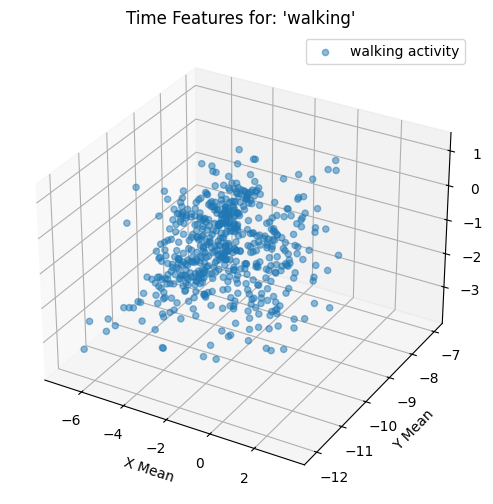

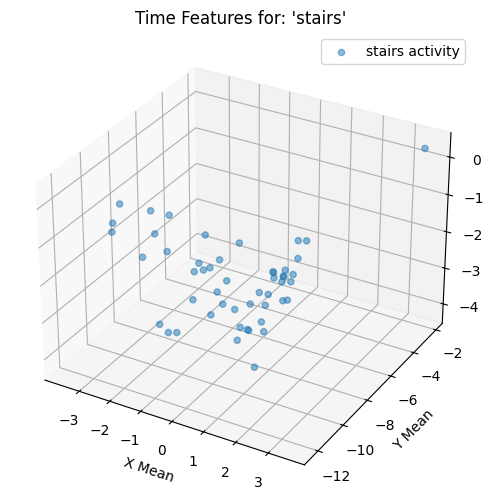

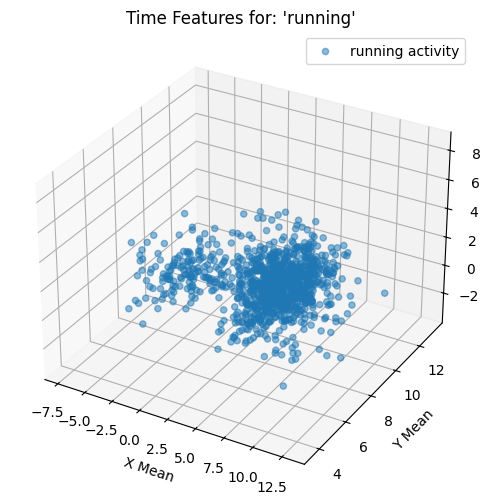

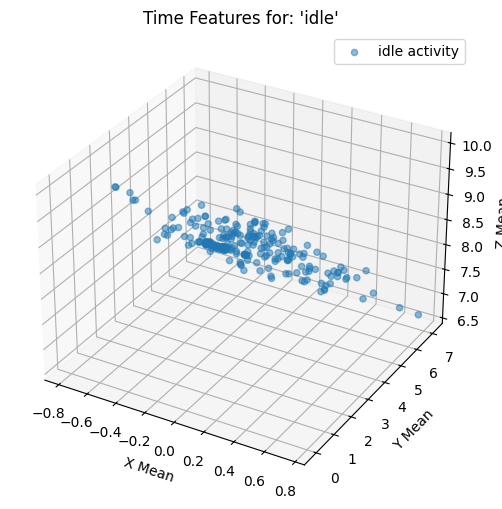

(        X_mean     X_std      X_min      X_max     Y_mean     Y_std  \
 0     0.162854  4.889193 -14.159308  12.363658  -9.523799  5.621535   
 1     0.747805  4.960746 -12.277467  11.113884 -10.630303  6.476651   
 2     0.520499  4.986660 -12.277467  11.113884 -10.708259  6.700259   
 3     0.101035  5.493051 -14.159308  11.894394 -10.991876  6.152316   
 4    -0.567091  5.251097 -12.277467  11.894394 -10.558765  6.448694   
 ...        ...       ...        ...        ...        ...       ...   
 1933  0.176261  0.655347  -2.044648   1.225831   1.993125  2.667436   
 1934  0.255701  0.564477  -2.044648   1.225831   0.675740  1.712919   
 1935  0.232094  0.309141  -1.599327   1.225831   0.085042  0.376288   
 1936  0.404716  0.036209   0.330400   0.488417  -0.024995  0.037707   
 1937  0.407206  0.035612   0.320823   0.488417  -0.027294  0.037006   
 
           Y_min     Y_max    Z_mean     Z_std      Z_min      Z_max  
 0    -25.201366  5.214572 -1.156830  6.824657 -26.302700  23.5

In [28]:
X, y = calculate_time_features(all_data)


def vis_time_features(X, y):
    activities_names = {v: k for k, v in activities.items()}
    df = X.copy()
    df["activity"] = y.map(activities_names)

    for activity in activities_names.values():
        activity_data = df[df["activity"] == activity]
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(
            activity_data["X_mean"],
            activity_data["Y_mean"],
            activity_data["Z_mean"],
            label=f"{activity} activity",
            alpha=0.5,
        )
        ax.set_xlabel("X Mean")
        ax.set_ylabel("Y Mean")
        ax.set_zlabel("Z Mean")
        ax.set_title(f"Time Features for: '{activity}'")
        ax.legend()
        plt.show()

vis_time_features(X, y)
X, y

Розділення даних на тестові та тренувальні, нормалізація:

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

Алгоритм SVM (навчання):

In [30]:
svm_model = SVC()
svm_model.fit(X_train_sc, y_train)
y_pred_svm = svm_model.predict(X_test_sc)

Алгоритм Random Forest (навчання):

In [31]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

Порівняння результатів роботи обох алгоритмів:

SVM Classification Report:
               precision    recall  f1-score   support

     walking       0.96      1.00      0.98       168
      stairs       1.00      0.65      0.79        20
     running       1.00      1.00      1.00       306
        idle       1.00      1.00      1.00        88

    accuracy                           0.99       582
   macro avg       0.99      0.91      0.94       582
weighted avg       0.99      0.99      0.99       582

Random Forest Classification Report:
               precision    recall  f1-score   support

     walking       0.97      0.99      0.98       168
      stairs       0.88      0.70      0.78        20
     running       1.00      1.00      1.00       306
        idle       1.00      1.00      1.00        88

    accuracy                           0.99       582
   macro avg       0.96      0.92      0.94       582
weighted avg       0.99      0.99      0.99       582



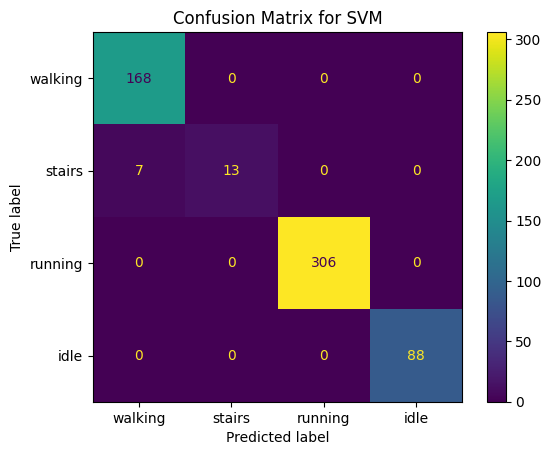

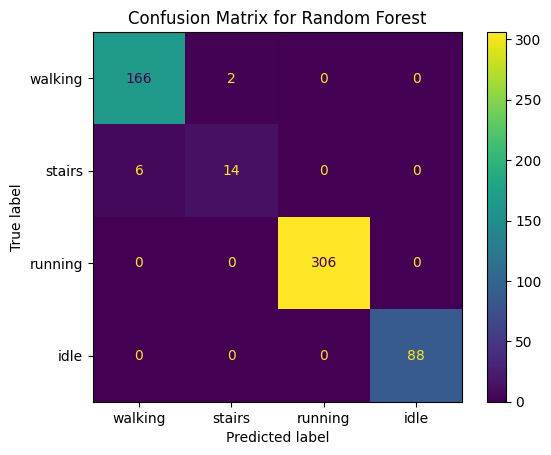

In [32]:
svm_report = classification_report(y_test, y_pred_svm, target_names=activities.keys())
rf_report = classification_report(y_test, y_pred_rf, target_names=activities.keys())

print("SVM Classification Report:\n", svm_report)
print("Random Forest Classification Report:\n", rf_report)

ConfusionMatrixDisplay.from_estimator(
    svm_model, X_test_sc, y_test, display_labels=activities.keys()
)
plt.title("Confusion Matrix for SVM")
plt.show()

ConfusionMatrixDisplay.from_estimator(
    rf_model, X_test, y_test, display_labels=activities.keys()
)
plt.title("Confusion Matrix for Random Forest")
plt.show()


<span style="color:green">Висновок:</span>  
Обидва алгоритма працюють добре, однак, в деяких випадках модель SVM краще працює з класом "stairs", на відміну від Random Forest.